# Data Preparation and cleaning

## Libraries

In [7]:
import numpy as np
import pandas as pd
import datetime as dt

import os
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [8]:
orders_path = '../orders_merged.csv'

df_orders = pd.read_csv(orders_path,
                       dtype=
                        {'Customer number': object,
                         'Gender': 'category',
                         'PoR': object,
                         'Order number': object,
                         'Product number': object,
                         'Sub category': 'category',
                         'Category': 'category',
                         'Count': np.int16,
                         'Price': np.float64,
                         'EDT': np.int16,
                         'ADT': np.int16,
                         'RoR': object,
                         'Rating': np.int8})

In [9]:
df_orders.head(5)

,Customer number,DoB,Gender,PoR,Order number,Order date,Product number,Sub category,Category,Count,Price,EDT,ADT,RoR,Rating
0,1063418,15-01-1944,Woman,Bloemendaal,1251137,20-12-2014,5146308036084,Garden chairs,Garden furniture,1,1090.82,2,2,NaN,-1
1,1062078,17-01-1934,Man,De Bilt,1658762,03-11-2017,8119187109467,Torches,Garden heating,6,385.92,4,4,NaN,-1
2,1007060,14-01-1947,Man,Doetinchem,106526,08-06-2013,6110364066490,Leaf blowers,Garden reamers,2,173.78,3,-1,No reason given,-1
3,1063418,15-01-1944,Woman,Bloemendaal,1251137,20-12-2014,8172375031575,Hoes,Garden hand tools,4,45.64,5,-1,Article is defect,-1
4,1063290,08-01-1971,Woman,Franekeradeel,439149,06-01-2015,8111132296154,Insects and vermin,Control,1,114.24,1,1,NaN,-1


## Feature engineering

### "Returned"
    -> binary value
    -> is the product retured or not

In [10]:
df_orders.loc[df_orders['RoR'].isnull(), 'Returned'] = 0
df_orders.loc[df_orders['RoR'].notnull(), 'Returned'] = 1
df_orders = df_orders.drop('RoR', axis=1)

### "Price per product"
    -> what is the price of the product ordered

In [11]:
df_orders['Price per Product'] = df_orders['Price'] / df_orders['Count']

### "Man" / "Woman"
    -> boolean values
    -> is the gender man or woman
    -> the method is called One-Hot-Encoding. It is done instead of changing the genders to 0 and 1 in the original column, so the models in the future can diferentiate them like categories, not numbers
    -> as there are statistically unimportant number of missing gender values, we will make both columns 'Man' and 'Woman' = 0

In [12]:
df_orders.loc[df_orders['Gender'] == "Man", 'Man'] = 1
df_orders.loc[df_orders['Gender'] == "Woman", 'Man'] = 0
df_orders.loc[df_orders['Gender'] == "Man", 'Woman'] = 0
df_orders.loc[df_orders['Gender'] == "Woman", 'Woman'] = 1

In [13]:
df_orders['Man'].replace(np.nan, 0, inplace=True)
df_orders['Woman'].replace(np.nan, 0, inplace=True)

### "Age" 
    -> based on the date of birth

In [14]:
today = dt.datetime.today()

df_orders["DoB"] = pd.to_datetime(df_orders["DoB"], format="%d-%m-%Y")
df_orders["Age"] = today.year - df_orders["DoB"].dt.year - ((today.month <= df_orders["DoB"].dt.month)
                                                            & (today.day <= df_orders["DoB"].dt.day))

### "Order month" and "Order year"
    -> separate the month and the year of an order for easier analysis

In [15]:
df_orders["Order date"] = pd.to_datetime(df_orders["Order date"], format="%d-%m-%Y")
df_orders["Order month"] = df_orders["Order date"].dt.month
df_orders["Order year"] = df_orders["Order date"].dt.year

### "DeltaT"
    -> number representation of the days
    -> the 0 day is 01-01-2013 and each next day is +1

In [16]:
first_order = pd.to_datetime("01-01-2013", format="%d-%m-%Y")
df_orders["DeltaT"] = (df_orders["Order date"] - first_order).dt.days

## Current information about the dataset

In [17]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5188084 entries, 0 to 5188083
Data columns (total 22 columns):
Customer number      object
DoB                  datetime64[ns]
Gender               category
PoR                  object
Order number         object
Order date           datetime64[ns]
Product number       object
Sub category         category
Category             category
Count                int16
Price                float64
EDT                  int16
ADT                  int16
Rating               int8
Returned             float64
Price per Product    float64
Man                  float64
Woman                float64
Age                  int64
Order month          int64
Order year           int64
DeltaT               int64
dtypes: category(3), datetime64[ns](2), float64(5), int16(3), int64(4), int8(1), object(4)
memory usage: 643.2+ MB


# Exploratory Data Analysis (EDA)

## Gender distribution

In [18]:
unique_gender = df_orders[['Customer number', 'Man', 'Woman']]
unique_gender = unique_gender.drop_duplicates('Customer number')

male = unique_gender[unique_gender['Man'] == 1]
female = unique_gender[unique_gender['Woman'] == 1]

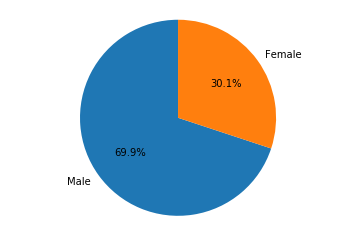

In [19]:
labels = 'Male', 'Female'
sizes = [len(male), len(female)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

plt.show()

## Age distribution

In [20]:
customers_age = df_orders[['Customer number', 'Age']]
customers_age = customers_age.drop_duplicates('Customer number')

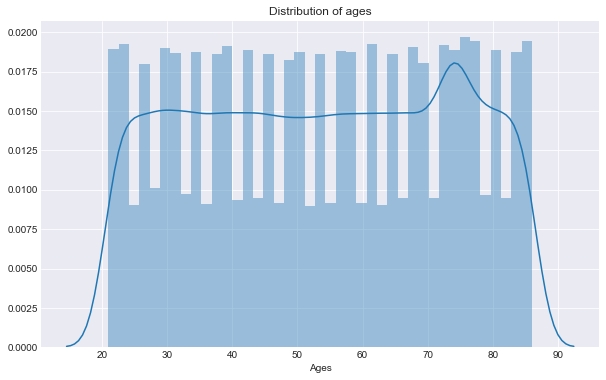

In [21]:
sns.set_style('darkgrid')
x = pd.Series(customers_age['Age'], name="Ages")
plt.subplots(figsize=(10,6))
sns.distplot(x)
plt.title("Distribution of ages")
print()

## Categories and subcategories

In [22]:
df_ordered_categories = df_orders.groupby(['Category', 'Sub category'])
print(df_ordered_categories[['Category', 'Sub category']].nunique().to_string())

                                                              Category  Sub category
Category          Sub category                                                      
Control           Grout brushes                                      1             1
                  Insects and vermin                                 1             1
                  Insects and vermin (2-pack)                        1             1
                  Weed brush                                         1             1
                  Weed brush (2-pack)                                1             1
                  Weed burner                                        1             1
                  Weed burner (2-pack)                               1             1
                  \                                                  1             1
                  Grout brushes (2-pack)                             1             1
Garden decoration Garden gnomes                                  

## Money earned per category

In [23]:
money_per_category = df_orders.groupby(['Category'])['Price'].sum()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
money_per_category

Category
Control               70751493.440
Garden decoration    183518378.580
Garden furniture    1218383672.760
Garden hand tools      9363004.640
Garden heating        83398360.450
Garden reamers        24795743.880
Gardening tools       60419147.290
Lounge furniture     298280127.020
Other furniture       63194462.500
Pruning               48473599.840
Sun protection       287442391.240
Watering             128984887.010
Name: Price, dtype: float64

## Distribution of orders per customer

In [24]:
df_orders = df_orders.sort_values(['Customer number', 'Order date'])

orders_per_customer = df_orders[['Customer number', 'Order number']]
orders_per_customer = orders_per_customer.groupby('Customer number')['Order number'].count().reset_index()
orders_per_customer.rename(columns = {'Order number' : 'Number of orders'}, inplace=True)

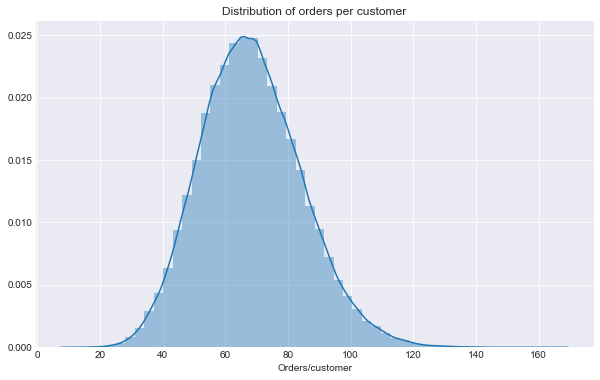

In [25]:
sns.set_style('darkgrid')
x = pd.Series(orders_per_customer['Number of orders'], name="Orders/customer")
plt.subplots(figsize=(10,6))
sns.distplot(x)
plt.title("Distribution of orders per customer")
print()

## Replacing all -1 values with NaN in 'Rating'

In [26]:
df_orders['Rating'].replace(-1, np.nan, inplace=True)

## Average rating per customer

In [27]:
rating_per_customer_avg = df_orders[['Customer number', 'Rating']]
rating_per_customer_avg.head()

,Customer number,Rating
389255,1004532,5.000
1461211,1004532,nan
312254,1004532,4.000
315189,1004532,4.000
1389454,1004532,nan


In [28]:
rating_per_customer_avg = rating_per_customer_avg.groupby('Customer number')['Rating'].mean().reset_index()

### Give all people that haven't given raiting an average raiting value of -1

In [29]:
rating_per_customer_avg['Rating'].replace(np.nan, -1, inplace=True)
rating_per_customer_avg.rename(columns = {'Rating' : 'Average rating'}, inplace=True)

## Estimated date of arrival / actual date of arrival

In [30]:
df_average_edt_divided_by_adt_per_customer = df_orders[['Customer number', 'EDT', 'ADT', 'Age']]

In [31]:
df_average_edt_divided_by_adt_per_customer = df_average_edt_divided_by_adt_per_customer.groupby('Customer number')['EDT', 'ADT'].mean().reset_index()

In [32]:
df_average_edt_divided_by_adt_per_customer['EDT_divided_ADT'] = df_average_edt_divided_by_adt_per_customer['EDT'] / df_average_edt_divided_by_adt_per_customer['ADT']

In [33]:
df_average_edt_divided_by_adt_per_customer.head()

,Customer number,EDT,ADT,EDT_divided_ADT
0,1004532,2.714,3.020,0.899
1,1004533,2.386,3.060,0.780
2,1004534,3.133,4.904,0.639
3,1004535,3.121,3.924,0.795
4,1004536,2.754,3.328,0.828


## Percent returned items

In [34]:
returns_per_customer = df_orders[['Customer number', 'Returned']]
total_returns = returns_per_customer.groupby('Customer number')['Returned'].count()
actual_returns = returns_per_customer[returns_per_customer['Returned'] == 1].groupby('Customer number')['Returned'].count()

returns_per_customer = returns_per_customer.drop_duplicates('Customer number')
returns_per_customer = returns_per_customer.drop('Returned', axis=1)

percentage_returned = actual_returns.divide(total_returns, fill_value=0).to_frame()
returns_per_customer = pd.merge(returns_per_customer, percentage_returned, how='left', on='Customer number')

## Churn analysis

### Get dates of orders per customer

In [35]:
dates_per_customer = df_orders[['Customer number', 'Order number', 'Order date']]
dates_per_customer = dates_per_customer.drop_duplicates('Order number')
dates_per_customer = dates_per_customer.drop('Order number', axis=1)

In [36]:
customer_dates = dates_per_customer.groupby('Customer number')['Order date'].apply(lambda x: x.tolist())
customer_dates_dict = customer_dates.to_dict()
customer_dates = customer_dates.reset_index()

### Calculate orders' date difference to determine churn
    -> the algorithm calculates the days difference between two consecutive orders and gets the mean of all differences + the standart deviation of all differences
    -> based on that we later determine if the customer has churned, using the date of his/hers last order

In [37]:
last_order_date = pd.Timestamp(df_orders['Order date'].max())

In [38]:
def calculate_mean(dates):
    days = np.empty(len(dates) - 1)
    for i, date in enumerate(dates):
        if i < len(dates) - 1:
            days[i] = ((dates[i + 1] - dates[i]).days)

    return round(days.mean()+days.std())

In [39]:
churn_array = np.empty(len(customer_dates_dict.items()))
meanstd_time_between_orders_array = np.empty(len(customer_dates_dict.items()))

for i, (key, value) in enumerate(customer_dates_dict.items()):
    meanstd_time_between_orders = calculate_mean(value)
    if (last_order_date - customer_dates_dict[key][-1]).days > meanstd_time_between_orders:
        churn_array[i] = 1
    else:
        churn_array[i] = 0
    meanstd_time_between_orders_array[i] = meanstd_time_between_orders

## Drop unessecary featutures and get unique customer numbers

In [40]:
df_orders = df_orders.drop(
    ['Order number', 'Order date', 'EDT', 'ADT', 'Rating', 'Returned'],
    axis=1).drop_duplicates().reset_index().drop('index', axis=1)

In [41]:
unique_ages_gender = df_orders[['Customer number', 'Age', 'Man', 'Woman']].drop_duplicates().reset_index().drop('index', axis=1)

## Create a dateset for customer churn analysis

In [42]:
customer_dates['T_between_orders'] = meanstd_time_between_orders_array
customer_dates['Number of orders'] = orders_per_customer['Number of orders']
customer_dates['Average rating'] = rating_per_customer_avg['Average rating']
customer_dates['Percentage returns'] = returns_per_customer['Returned']
customer_dates['EDT'] = df_average_edt_divided_by_adt_per_customer['EDT']
customer_dates['ADT'] = df_average_edt_divided_by_adt_per_customer['ADT']
customer_dates['EDT_divided_ADT'] = df_average_edt_divided_by_adt_per_customer['EDT_divided_ADT']
customer_dates['Man'] = unique_ages_gender['Man']
customer_dates['Woman'] = unique_ages_gender['Woman']
customer_dates['Age'] = unique_ages_gender['Age']
customer_dates['Churn'] = churn_array
customer_dates.drop('Order date', axis=1, inplace=True)
customer_dates.dropna(inplace=True)

customer_dates.to_csv('../orders_churn.csv', index=False)

## Plots

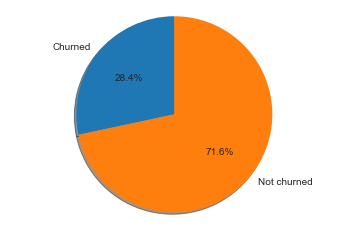

In [43]:
labels = ['Churned', 'Not churned']
fig, ax = plt.subplots()
x = customer_dates[customer_dates['Churn'] == 1]['Churn'].count()
y = customer_dates[customer_dates['Churn'] == 0]['Churn'].count()
ax.pie([x, y], labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')

plt.show()

In [44]:
last_order_date

Timestamp('2018-12-09 00:00:00')

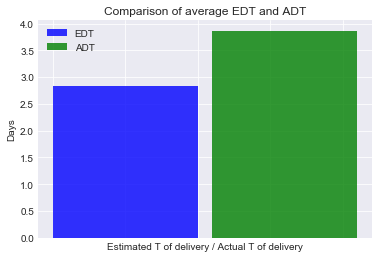

In [45]:
# data to plot
n_groups = 1
mean_edt = customer_dates['EDT'].mean()
mean_adt = customer_dates['ADT'].mean()

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, mean_edt, 0.1,
                 alpha=opacity,
                 color='b',
                 label='EDT')
 
rects2 = plt.bar(index + 0.11, mean_adt, 0.1,
                 alpha=opacity,
                 color='g',
                 label='ADT')
 
plt.xlabel('Estimated T of delivery / Actual T of delivery')
plt.ylabel('Days')
plt.title('Comparison of average EDT and ADT')
plt.tick_params(bottom=False, labelbottom=False)
plt.legend()

plt.show()

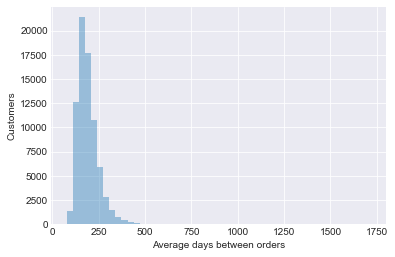

In [46]:
ax = sns.distplot(customer_dates['T_between_orders'], kde=False)
ax.set(xlabel='Average days between orders', ylabel='Customers')
plt.show()

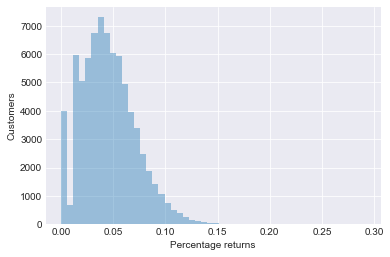

In [47]:
ax = sns.distplot(customer_dates['Percentage returns'], kde=False)
ax.set(ylabel='Customers')
plt.show()

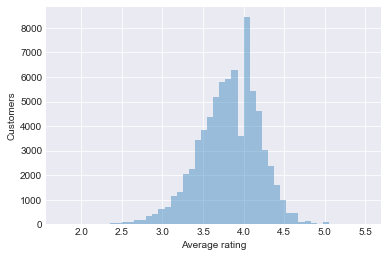

In [48]:
ax = sns.distplot(customer_dates['Average rating'], kde=False, 
                  hist_kws={'range':[1.75,5.5]})
ax.set(ylabel='Customers')
plt.show()

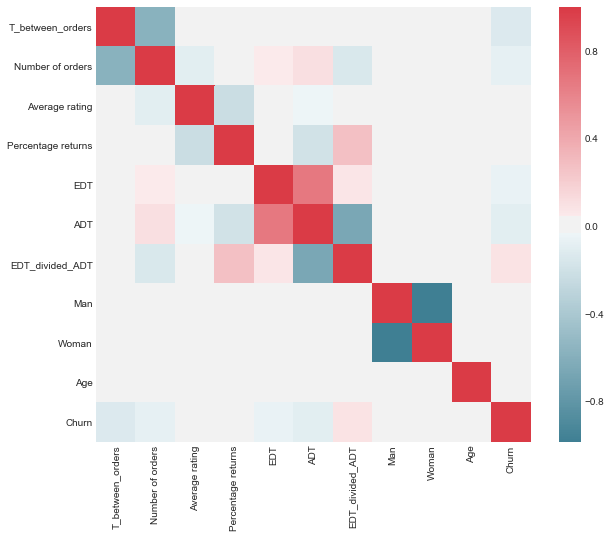

In [49]:
f, ax = plt.subplots(figsize=(10, 8))
corr = customer_dates.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

# Distribution of variables in customer churn

In [50]:
customer_dates.drop('EDT_divided_ADT', inplace = True, axis = 1)
churn     = customer_dates[customer_dates["Churn"] == 1]
not_churn = customer_dates[customer_dates["Churn"] == 0]

targetCol = ["Churn"]
catCols = customer_dates.nunique()[customer_dates.nunique() < 6].keys().tolist()
catCols = [x for x in catCols if x not in targetCol]

numerics = ['float64', 'int64']
numeric_df = customer_dates.select_dtypes(include=numerics)
objects_df = customer_dates.select_dtypes(exclude=numerics)

keyCol = ['Customer number']
numCols = [x for x in customer_dates.columns if x not in catCols + keyCol + targetCol]

In [51]:
from matplotlib.ticker import PercentFormatter

def histChart(column):
    values_churn = churn[column]
    legend = ['Churn', 'Non churn']
    values_nonchurn = not_churn[column]
    plt.hist([values_churn, values_nonchurn], color=['orange', 'blue'], bins=20, rwidth=0.5, density=1)
    #plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.xlabel(column, fontsize=16)
    plt.legend(legend)
    plt.title(column + ' distribution in customer churn', fontsize=16)
    plt.rcParams['figure.figsize'] = (20,7)
    plt.show()

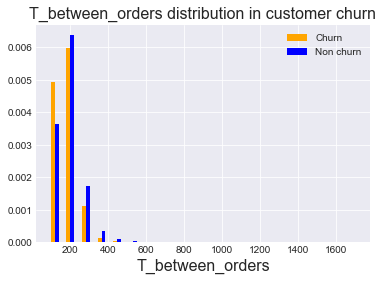

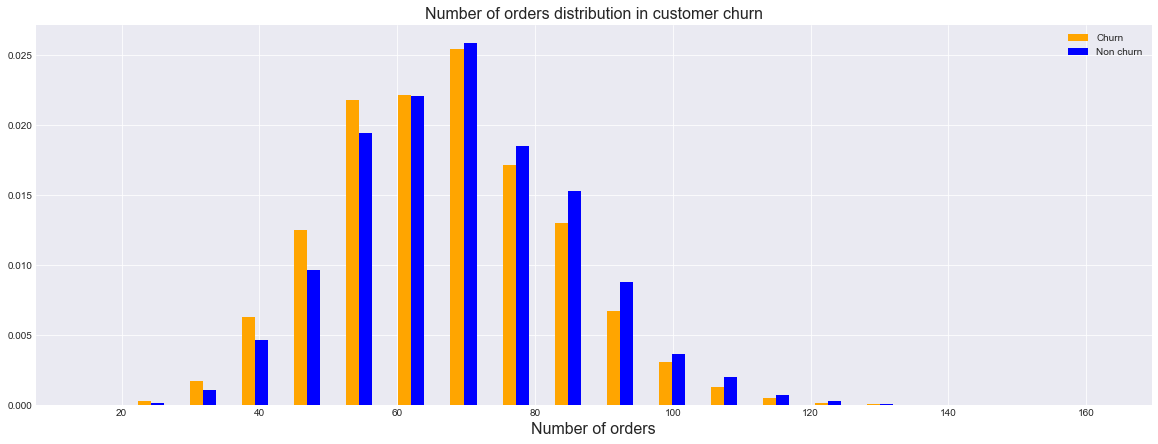

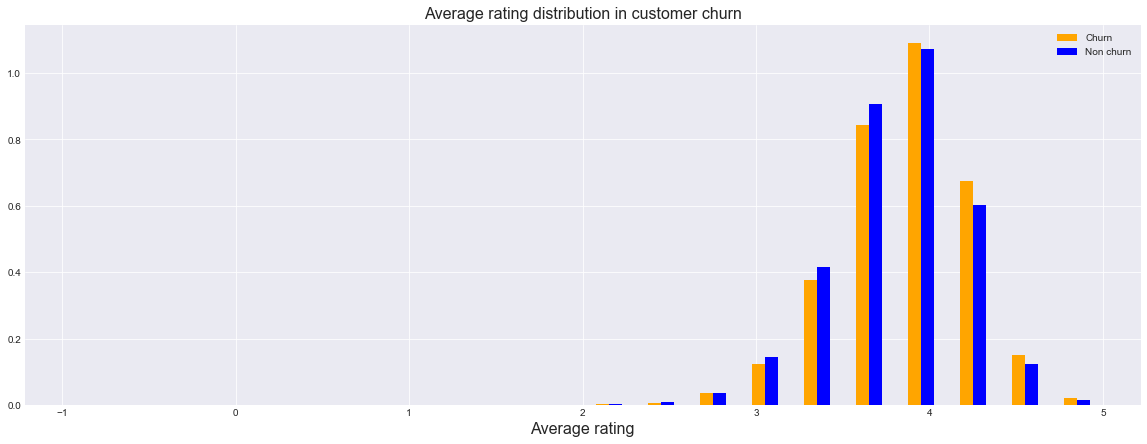

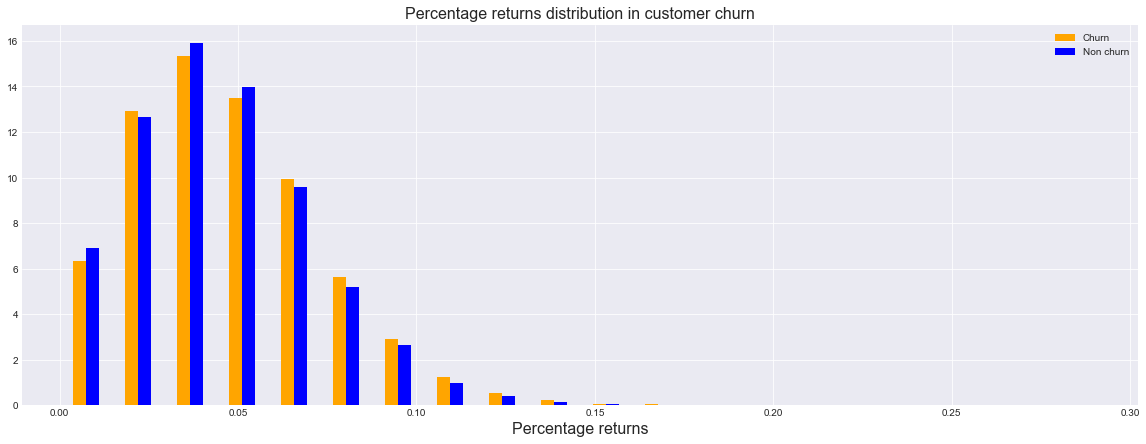

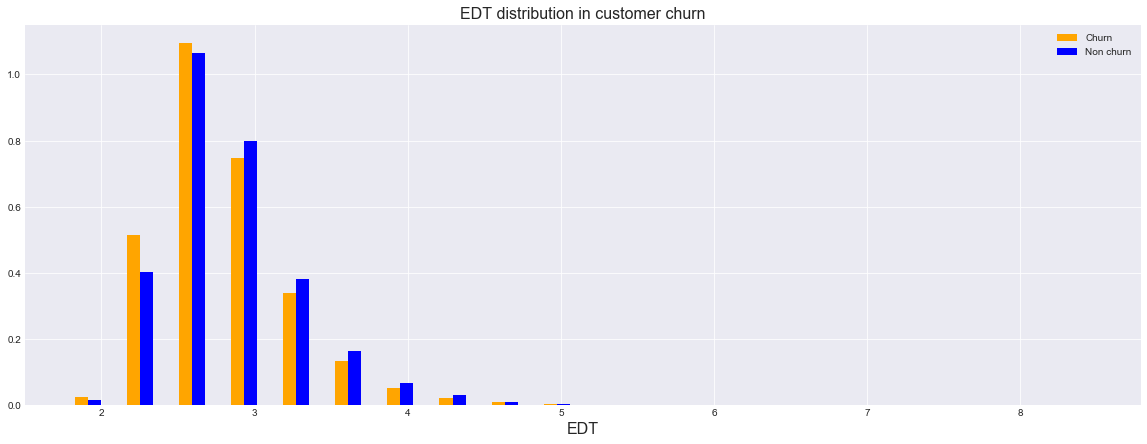

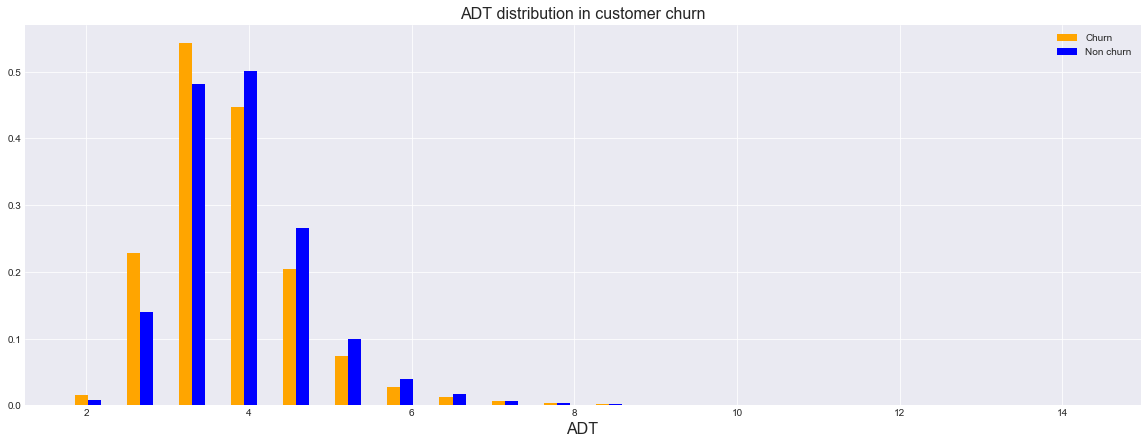

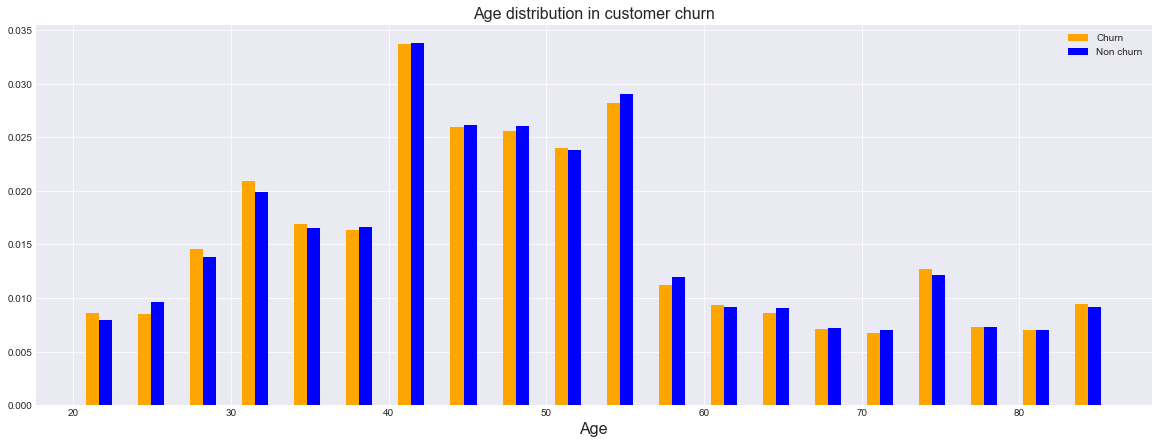

In [52]:
for i in numCols:
    histChart(i)
    print("\n\n")